<a href="https://colab.research.google.com/github/ckodser/RFCL/blob/main/tresholdActivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [413]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [414]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [415]:
batch_size = 256
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 1, 28, 28])
Shape of y:  torch.Size([256]) torch.int64


In [416]:
class TrasholdActivationFunction(torch.autograd.Function):

    @staticmethod
    # bias is an optional argument
    def forward(ctx, input):
        return (input>0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output;

In [417]:
class TrasholdActivation(nn.Module):
    def __init__(self):
        super(TrasholdActivation, self).__init__()
        
    def forward(self, input):
        return TrasholdActivationFunction.apply(input)

In [418]:
# Get cpu or gpu device for training.1
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,activation_function):
        super(NeuralNetwork, self).__init__()
        self.activation=activation_function
        self.channels=[1,7,10,15,20,30]
        self.l=len(self.channels)
        self.size=[28*28,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,10]
        self.grouplayer=[nn.Sequential(#nn.Dropout(p=0.8),
            nn.Conv2d(self.channels[i], self.channels[i+1], (3,3),device=device),
            self.activation) for i in range(self.l-1)]
        
        self.cnn = nn.Sequential(
            self.grouplayer[0],
            self.grouplayer[1],
            self.grouplayer[2],
            self.grouplayer[3],
            self.grouplayer[4]
        )
        
        self.outlayers=nn.Sequential(
           # nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(9720, 10,device=device),
            nn.Softmax(dim=1)      
        )

        self.whole_system=nn.Sequential(
            self.cnn,
            self.outlayers
        )

    def forward(self, x):
        output=[None]
        for i in range(self.l-1):
            x=self.grouplayer[i](x)
            output.append(x)
        x=self.outlayers(x)
        output[0]=x
        return output
    
model = NeuralNetwork(TrasholdActivation()).to(device)
print(model)

Using cuda device
NeuralNetwork(
  (activation): TrasholdActivation()
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): TrasholdActivation()
    )
    (1): Sequential(
      (0): Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): TrasholdActivation()
    )
    (2): Sequential(
      (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
      (1): TrasholdActivation()
    )
    (3): Sequential(
      (0): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): TrasholdActivation()
    )
    (4): Sequential(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
      (1): TrasholdActivation()
    )
  )
  (outlayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9720, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
  (whole_system): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
        (1): T

In [427]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.0001)
#optimizer =torch.optim.Adam(  model.parameters(), lr=0.001)
#normalOptimizer = torch.optim.Adam( normalModel.parameters(), lr=0.001)
history=[]

In [428]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)[0]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
           # return #for testing pytorch
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [429]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def drawWeights(model):
  linear_layers=[1,4,7,10,13,16,19]
  n_bins = 20
  fig, axs = plt.subplots(2, 4, sharey=False, tight_layout=True)
  # We can set the number of bins with the `bins` kwarg
  for j in range(len(linear_layers)):
      i=linear_layers[j]
      axs[j//4][j%4].hist(model.linear_relu_stack[i].weight.data.cpu().numpy().flatten(), bins=n_bins)
  plt.show()
  

In [430]:
from torch import linalg as LA
def treshold_loss(output):
  active=torch.mean(output,dim=0)
  active-=0.05
  active=active*active
  return torch.sqrt(torch.sum(active))


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        output=model(X)
        pred = output[0]
        loss=loss_fn(pred, y)
        output_norm_loss=loss*0
        '''
        print("LOSS")
        print(loss)
        print("Y shape")
        print(y.shape)
        print("pred shape")
        print(pred.shape)
        print("loss shape")
        print(loss.shape)
        '''
        
        for i in range(1,len(output)):
            b=treshold_loss(output[i])*0.01
            '''
            print("BBBBBBBBBBB")
            print(b)
            print(b.shape)
            print("$$$$$$$$$$$$")
            '''
            output_norm_loss=output_norm_loss+b
        # Backpropagation
        loss+=output_norm_loss
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
       # return
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(batch)
            print(f"loss: {loss:>7f} output norm: {output_norm_loss:>7f} [{current:>5d}/{size:>5d}]")

Test Error: 
 Accuracy: 71.1%, Avg loss: 0.006992 

Epoch 1
-------------------------------
0
loss: 3.349960 output norm: 1.625905 [    0/60000]
100
loss: 3.386274 output norm: 1.565356 [25600/60000]
200
loss: 3.408859 output norm: 1.557102 [51200/60000]
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.006975 



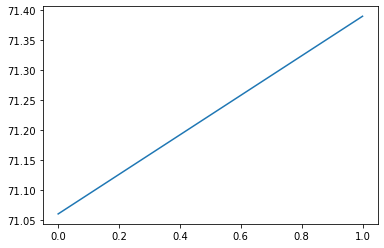

Epoch 2
-------------------------------
0
loss: 3.374458 output norm: 1.660512 [    0/60000]
100
loss: 3.380200 output norm: 1.658575 [25600/60000]
200
loss: 3.379743 output norm: 1.604154 [51200/60000]
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.006975 



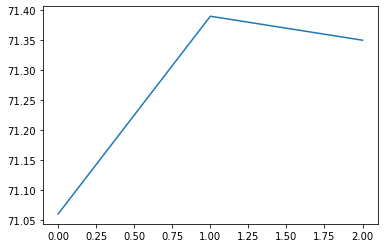

Epoch 3
-------------------------------
0
loss: 3.373001 output norm: 1.660555 [    0/60000]
100
loss: 3.375513 output norm: 1.654205 [25600/60000]
200
loss: 3.402592 output norm: 1.556908 [51200/60000]
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.007003 



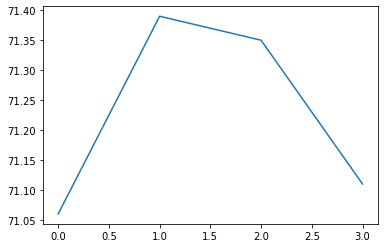

Epoch 4
-------------------------------
0
loss: 3.351138 output norm: 1.622562 [    0/60000]
100
loss: 3.380939 output norm: 1.654906 [25600/60000]
200
loss: 3.400580 output norm: 1.556628 [51200/60000]
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.006956 



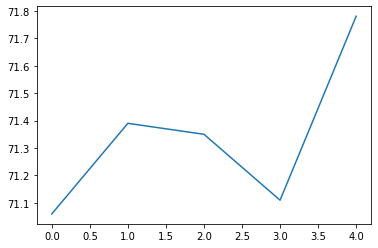

Epoch 5
-------------------------------
0
loss: 3.367729 output norm: 1.656619 [    0/60000]
100
loss: 3.364851 output norm: 1.638182 [25600/60000]
200
loss: 3.343344 output norm: 1.575493 [51200/60000]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.006945 



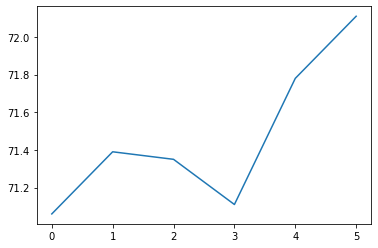

Epoch 6
-------------------------------
0
loss: 3.350468 output norm: 1.639500 [    0/60000]
100
loss: 3.396536 output norm: 1.575578 [25600/60000]
200
loss: 3.387105 output norm: 1.555978 [51200/60000]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.006948 



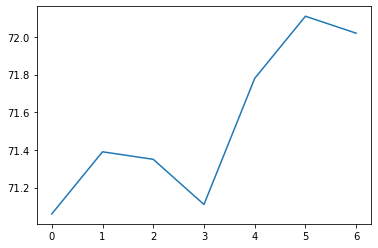

Epoch 7
-------------------------------
0
loss: 3.369142 output norm: 1.657601 [    0/60000]
100
loss: 3.366714 output norm: 1.645313 [25600/60000]
200
loss: 3.384339 output norm: 1.555868 [51200/60000]
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.006946 



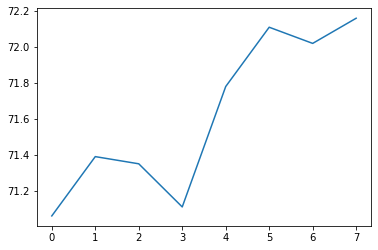

Epoch 8
-------------------------------
0
loss: 3.374944 output norm: 1.662761 [    0/60000]
100
loss: 3.363253 output norm: 1.645411 [25600/60000]
200
loss: 3.383800 output norm: 1.555971 [51200/60000]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.006944 



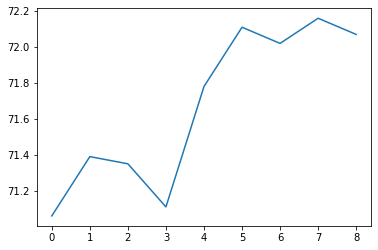

Epoch 9
-------------------------------
0
loss: 3.369541 output norm: 1.659107 [    0/60000]
100
loss: 3.333809 output norm: 1.611019 [25600/60000]
200
loss: 3.378795 output norm: 1.555909 [51200/60000]
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.006935 



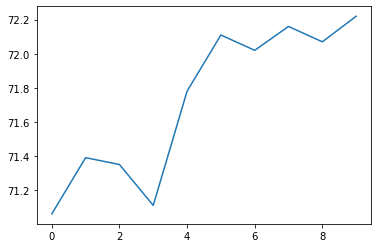

Epoch 10
-------------------------------
0
loss: 3.349504 output norm: 1.642690 [    0/60000]
100
loss: 3.372238 output norm: 1.576051 [25600/60000]
200
loss: 3.370651 output norm: 1.624554 [51200/60000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.006999 



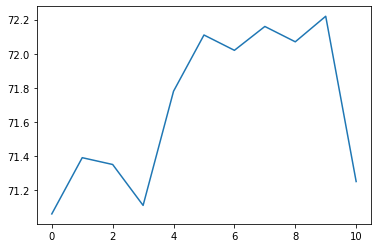

Epoch 11
-------------------------------
0
loss: 3.349052 output norm: 1.631699 [    0/60000]
100
loss: 3.367418 output norm: 1.576694 [25600/60000]
200
loss: 3.376748 output norm: 1.614190 [51200/60000]
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.007194 



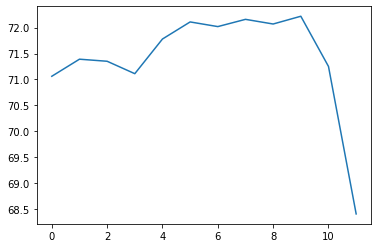

Epoch 12
-------------------------------
0
loss: 3.346068 output norm: 1.573498 [    0/60000]
100
loss: 3.385976 output norm: 1.660097 [25600/60000]
200
loss: 3.383913 output norm: 1.563386 [51200/60000]
Test Error: 
 Accuracy: 67.5%, Avg loss: 0.007120 



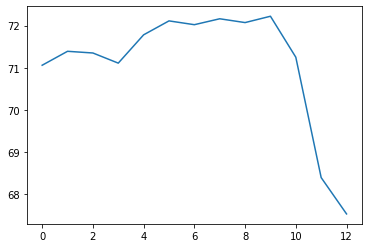

Epoch 13
-------------------------------
0
loss: 3.402336 output norm: 1.650330 [    0/60000]
100
loss: 3.350885 output norm: 1.572880 [25600/60000]
200
loss: 3.358139 output norm: 1.577661 [51200/60000]
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.007103 



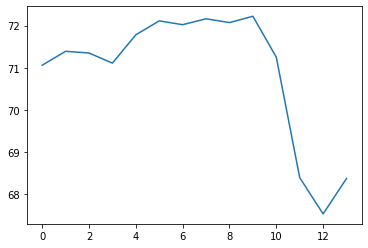

Epoch 14
-------------------------------
0
loss: 3.376228 output norm: 1.635757 [    0/60000]
100
loss: 3.421806 output norm: 1.634472 [25600/60000]
200
loss: 3.345368 output norm: 1.575112 [51200/60000]
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.007137 



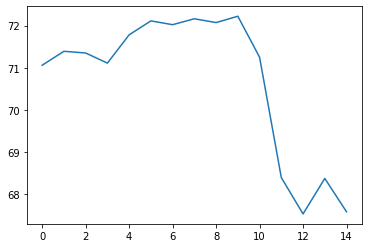

Epoch 15
-------------------------------
0
loss: 3.374810 output norm: 1.634649 [    0/60000]
100
loss: 3.411994 output norm: 1.633686 [25600/60000]
200
loss: 3.326440 output norm: 1.556061 [51200/60000]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.007109 



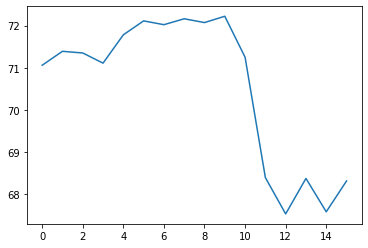

Epoch 16
-------------------------------
0
loss: 3.379375 output norm: 1.634466 [    0/60000]
100
loss: 3.413385 output norm: 1.640471 [25600/60000]
200
loss: 3.327282 output norm: 1.555940 [51200/60000]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.007153 



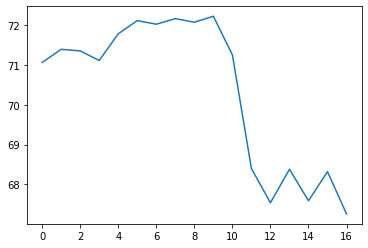

Epoch 17
-------------------------------
0
loss: 3.324350 output norm: 1.563846 [    0/60000]
100
loss: 3.384465 output norm: 1.609695 [25600/60000]
200
loss: 3.378560 output norm: 1.621642 [51200/60000]
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.007156 



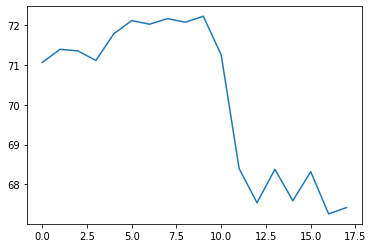

Epoch 18
-------------------------------
0
loss: 3.330625 output norm: 1.572421 [    0/60000]
100
loss: 3.380119 output norm: 1.608849 [25600/60000]
200
loss: 3.369187 output norm: 1.614063 [51200/60000]
Test Error: 
 Accuracy: 68.5%, Avg loss: 0.007105 



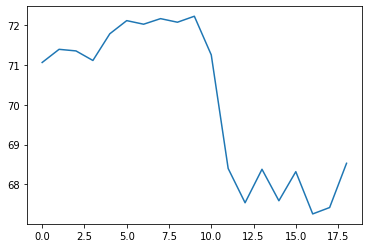

Epoch 19
-------------------------------
0
loss: 3.372903 output norm: 1.639618 [    0/60000]
100
loss: 3.396381 output norm: 1.633237 [25600/60000]
200
loss: 3.396125 output norm: 1.626121 [51200/60000]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.007155 



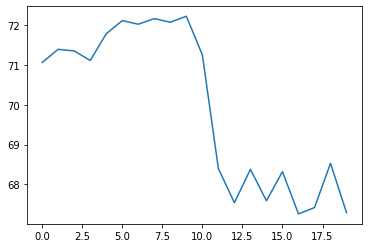

Epoch 20
-------------------------------
0
loss: 3.311354 output norm: 1.565855 [    0/60000]
100
loss: 3.400580 output norm: 1.640027 [25600/60000]
200
loss: 3.365166 output norm: 1.592570 [51200/60000]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.007092 



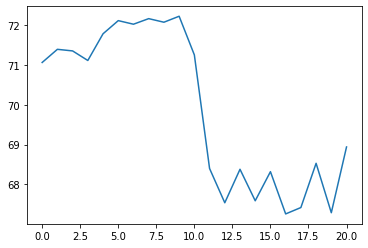

Epoch 21
-------------------------------
0
loss: 3.366168 output norm: 1.638829 [    0/60000]
100
loss: 3.401417 output norm: 1.644493 [25600/60000]
200
loss: 3.320974 output norm: 1.547241 [51200/60000]
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.007148 



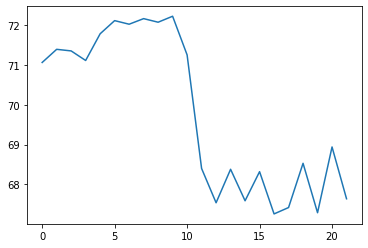

Epoch 22
-------------------------------
0
loss: 3.351705 output norm: 1.611824 [    0/60000]
100
loss: 3.319901 output norm: 1.565692 [25600/60000]
200
loss: 3.413484 output norm: 1.621122 [51200/60000]
Test Error: 
 Accuracy: 68.2%, Avg loss: 0.007121 



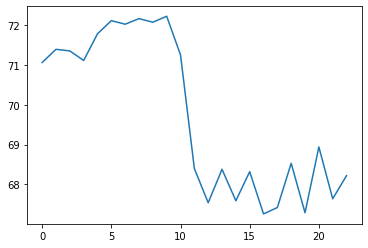

Epoch 23
-------------------------------
0
loss: 3.297281 output norm: 1.562853 [    0/60000]
100
loss: 3.411084 output norm: 1.644546 [25600/60000]
200
loss: 3.365668 output norm: 1.613544 [51200/60000]
Test Error: 
 Accuracy: 68.6%, Avg loss: 0.007109 



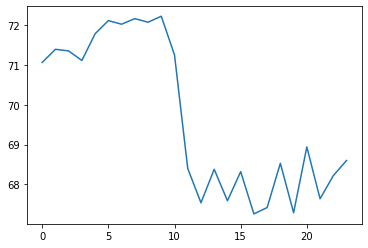

Epoch 24
-------------------------------
0
loss: 3.300314 output norm: 1.572157 [    0/60000]
100
loss: 3.368495 output norm: 1.613489 [25600/60000]
200
loss: 3.348269 output norm: 1.584231 [51200/60000]
Test Error: 
 Accuracy: 68.5%, Avg loss: 0.007108 



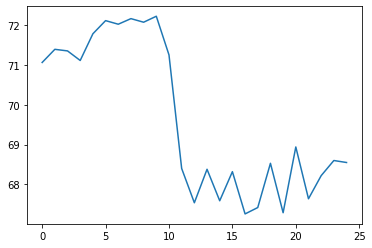

Epoch 25
-------------------------------
0
loss: 3.300051 output norm: 1.572100 [    0/60000]
100
loss: 3.334243 output norm: 1.572762 [25600/60000]
200
loss: 3.373824 output norm: 1.604574 [51200/60000]
Test Error: 
 Accuracy: 69.4%, Avg loss: 0.007075 



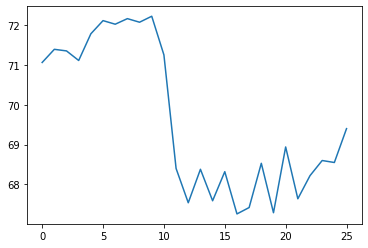

Epoch 26
-------------------------------
0
loss: 3.366724 output norm: 1.639400 [    0/60000]
100
loss: 3.344995 output norm: 1.586329 [25600/60000]
200
loss: 3.343353 output norm: 1.582482 [51200/60000]
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.007101 



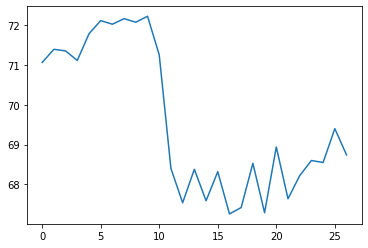

Epoch 27
-------------------------------
0
loss: 3.294411 output norm: 1.571816 [    0/60000]
100
loss: 3.482802 output norm: 1.642990 [25600/60000]
200
loss: 3.357331 output norm: 1.610962 [51200/60000]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.007104 



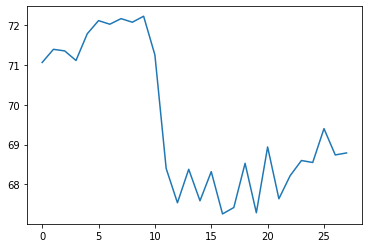

Epoch 28
-------------------------------
0
loss: 3.321801 output norm: 1.592049 [    0/60000]
100
loss: 3.417731 output norm: 1.638130 [25600/60000]
200
loss: 3.342627 output norm: 1.610809 [51200/60000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.007050 



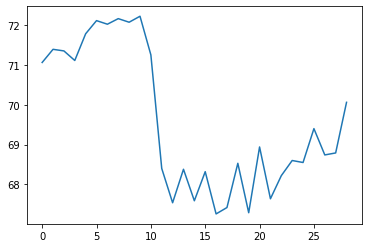

Epoch 29
-------------------------------
0
loss: 3.356536 output norm: 1.630739 [    0/60000]


KeyboardInterrupt: ignored

In [431]:
epochs = 30
history.append(test(test_dataloader, model))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #drawWeights(model)
    history.append(test(test_dataloader, model))
    plt.plot(np.arange(len(history)), history)
    plt.show()
